Tutorial presented at the LSST Workshop 2017, Santiago, Chile

Discrimination of RR Lyrae light curves from the VVV survey. 
1. Periodicity detection in light curves using mutual information (P4J) 
- Feature extraction using Gaussian proccesses (scikit-learn)
- Dimensionality reduction using PCA (scikit-learn) and autoencoders (tensorflow)
- Interactive visualization of the reduced feature space using bokeh
- Transductive classification using a positive-unlabeled (PU) random forest

Installing additional dependencies not in the jupyterhub

In [1]:
!pip install --user P4J
!pip install --user bokeh
!pip install --user joblib

In [1]:
import numpy as np
import P4J
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib import rcParams
from os import listdir
from os.path import join
import pickle
rcParams.update({'font.size': 12})

Load a light curve from data folder

['noisy.dat', 'rrl.dat', 'eb.dat', 'lpv.dat']


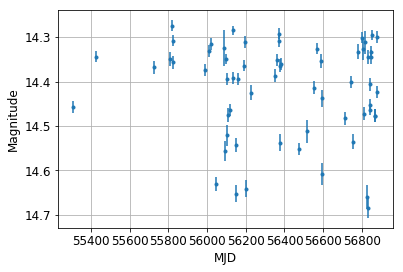

In [7]:
print([each for each in listdir('data') if each.endswith('.dat')])
# Selected one of the light curves
lc_data = np.loadtxt(join('data', 'rrl.dat'))
fla = np.asarray(lc_data[:, 3])
mjd = np.asarray(lc_data[:, 0])[fla==-1]
mag = np.asarray(lc_data[:, 1])[fla==-1]
err = np.asarray(lc_data[:, 2])[fla==-1]
N = len(mjd)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(mjd, mag, err, fmt='.')
ax.invert_yaxis()
ax.set_xlabel('MJD')
ax.set_ylabel('Magnitude')
plt.grid()

## Period estimation 

Compute mutual information periodogram

Best period: 0.440806 days


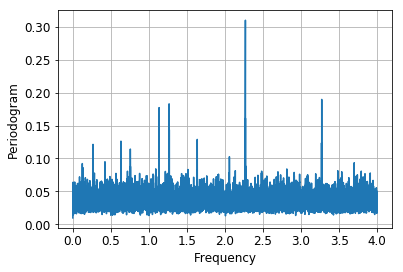

In [8]:
my_per = P4J.periodogram(method='QMIEU') 
my_per.set_data(mjd, mag, err, h_KDE_P=0.5)
my_per.frequency_grid_evaluation(fmin=0.0, fmax=4.0, fresolution=1e-4)
my_per.finetune_best_frequencies(fresolution=1e-5, n_local_optima=10)
freq, per = my_per.get_periodogram()
fbest, pbest  = my_per.get_best_frequencies()

plt.plot(freq, per)
plt.xlabel('Frequency')
plt.ylabel('Periodogram')
plt.grid()
print("Best period: %f days" %(1.0/fbest[0]))

Find the significance of the maximum of the using bootstrap resampling and Generalized Extreme Value (GEV) distributions

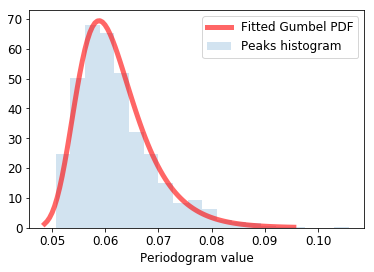

In [9]:
from scipy.stats import gumbel_r

pbest_bootstrap = np.zeros(shape=(10, 100))
for i in range(10):
    P = np.random.permutation(len(mjd))
    my_per.set_data(mjd, mag[P], err[P], h_KDE_P=0.5)
    my_per.frequency_grid_evaluation(fmin=0.0, fmax=4.0, fresolution=1e-3)
    my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=100)
    _, pbest_bootstrap[i, :] = my_per.get_best_frequencies()

param = gumbel_r.fit(pbest_bootstrap.ravel())
_ = plt.hist(pbest_bootstrap.ravel(), bins=20, normed=True, alpha=0.2, label='Peaks histogram')
rv = gumbel_r(loc=param[0], scale=param[1])
x = np.linspace(rv.ppf(0.001), rv.ppf(0.999), 100)
plt.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='Fitted Gumbel PDF')
plt.xlabel('Periodogram value')
plt.legend()

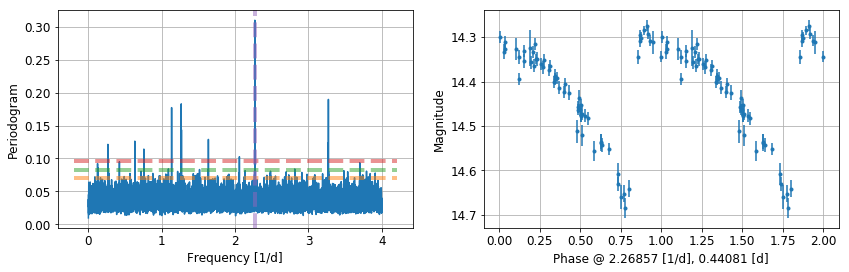

In [10]:
fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(freq, per)
# Print confidence bars
xmin, xmax = ax.get_xlim()
for p_val in [0.9, 0.99, 0.999]:
    ax.plot([xmin, xmax], [rv.ppf(p_val), rv.ppf(p_val)], '--', linewidth=4, alpha=0.5)

# Print max of periodogram
ymin, ymax = ax.get_ylim()
ax.plot([fbest[0], fbest[0]], [ymin, ymax], '--', linewidth=4, alpha=0.5)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/d]')
ax.set_ylabel('Periodogram')
plt.grid()

ax = fig.add_subplot(1, 2, 2)
f_fold = fbest[0]
phase = np.mod(mjd, 1.0/f_fold)*f_fold
I = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase), np.sort(phase)+1.0]), 
            np.concatenate([mag[I], mag[I]]),
            np.concatenate([err[I], err[I]]), fmt='.')

ax.invert_yaxis()
ax.set_xlabel('Phase @ %0.5f [1/d], %0.5f [d]' %(f_fold, 1.0/f_fold))
ax.set_ylabel('Magnitude')
plt.grid()

## Obtain features by fitting a periodic Gaussian process (scikit-learn)

- We fit the folded light curves ($\phi = mod(t, P)/P$, where $P$ is the period found with mutual information)
- We do a periodic fit using a Periodic kernel $\exp(-2 \sin^2(\pi \Delta t f)/\sigma^2)$ with $f=1$, this connects the fit in $\phi = 0$ and $\phi = 1$
- Heteroscedastic GP regression is more appropiate if error bars differ much: http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/heteroscedastic_regression.ipynb
- Add an additional $\sigma^2$ term to fit the noise (WhiteKernel)
- In practice you will have to remove outliers before fitting the GP

In [11]:
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
gpr = GaussianProcessRegressor(kernel=ExpSineSquared(periodicity=1.0, periodicity_bounds=(0.9999, 1.0001)) \
                               + WhiteKernel(), alpha=err**2, normalize_y=True, n_restarts_optimizer=5)
gpr.fit(X=(np.mod(mjd, 1.0/fbest[0])*fbest[0])[:, np.newaxis], y=mag[:, np.newaxis])
print(gpr.kernel_)

ExpSineSquared(length_scale=0.797, periodicity=1) + WhiteKernel(noise_level=4.02e-05)


Normalized Mean Square Error (NMSE): 0.155655
Normalized Sum of first differences (NSFD) 0.332121


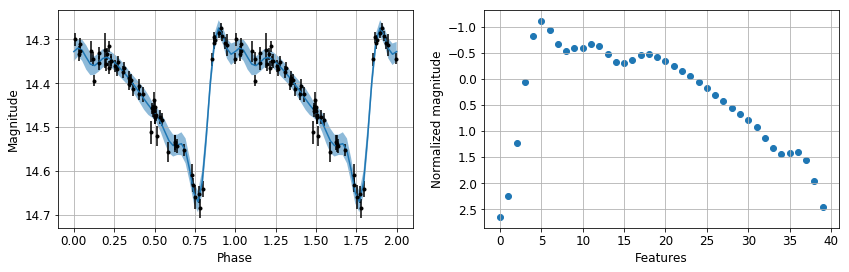

In [12]:
phi = np.linspace(0.0, 1.0, num=40)[:, np.newaxis]
gp_mu, gp_std = gpr.predict(X=phi, return_std=True)

fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.hstack((phi[:, 0], phi[:, 0]+1)), np.hstack((gp_mu[:, 0], gp_mu[:, 0])))
ax.fill_between(np.hstack((phi[:, 0], phi[:, 0]+1)), 
                 np.hstack((gp_mu[:, 0], gp_mu[:, 0])) - 2* np.hstack((gp_std, gp_std)), 
                 np.hstack((gp_mu[:, 0], gp_mu[:, 0])) + 2* np.hstack((gp_std, gp_std)), alpha=0.5)
ax.errorbar(np.hstack((phase, phase+1)), np.hstack((mag, mag)), np.hstack((err, err)), fmt='.', c='k')
ax.invert_yaxis()
plt.grid()
plt.xlabel('Phase')
plt.ylabel('Magnitude')

ax = fig.add_subplot(1, 2, 2)
idx_max = np.argmax(gp_mu)
gp_mu = np.roll(gp_mu, -idx_max)
ax.scatter(np.arange(40), (gp_mu - np.median(gp_mu))/np.std(gp_mu))
ax.invert_yaxis()
plt.xlabel('Features')
plt.ylabel('Normalized magnitude')
plt.grid()

gp_mu_train = gpr.predict(X=(np.mod(mjd, 1.0/fbest[0])*fbest[0])[:, np.newaxis], return_std=False)
w_mean = np.average(mag, weights=1.0/err**2)
w_var = np.average((mag - w_mean)**2, weights=1.0/err**2)
w_mse = np.average((mag - gp_mu_train[:, 0])**2, weights=1.0/err**2)
fit_quality = np.sqrt(w_mse/w_var)
fit_smoothness = np.sqrt(np.average((gp_mu[1:] - gp_mu[:-1])**2))/np.amax([np.sqrt(w_var), np.std(gp_mu)])
print("Normalized Mean Square Error (NMSE): %f\nNormalized Sum of first differences (NSFD) %f" %(fit_quality, fit_smoothness))

Features were computed offline using the procedure described above. Here we load the features for 10,000 VVV light curves

In [13]:
lc_periods = pickle.load(open("data/lc_periods.pkl", "rb"))
data_P = pickle.load(open("data/features_P.pkl", "rb"))
data_U = pickle.load(open("data/features_U.pkl", "rb"))

feature_names = list()
for i in range(40):
    feature_names.append("GP%d" %(i+1))
feature_names.append('NMSE')
feature_names.append('NSFD')
feature_names.append('Median')
feature_names.append('IQR')
feature_names.append('Skewness')
feature_names.append('Kurtosis')
feature_names.append('Freq')

The features are the GP fit (40), statistical moments of the original light curves (4), plus the inverse of the period (1) and two metrics that measure the quality of the fit:
- NMSE: Mean squared difference between data and model divided by data variance
- NSFD: Mean squared differences between succesive points from in the model, it measures the smoothness of the fit

Text(0.5,1,'Average fit in P set')

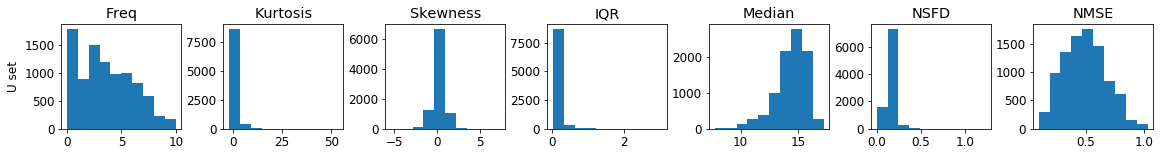

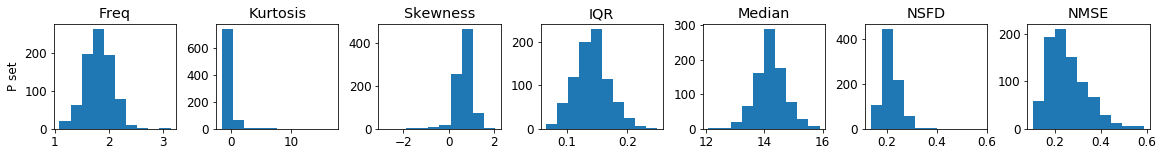

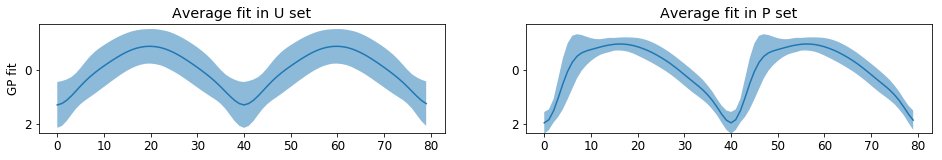

In [14]:
fig = plt.figure(figsize=(16, 2))
for i in range(7):
    ax = fig.add_subplot(1, 7, i+1)
    ax.hist(data_U[:, -i-1])
    ax.set_title(feature_names[-i-1])
    if i == 0:
        ax.set_ylabel('U set')
plt.tight_layout(pad=0.1)

fig = plt.figure(figsize=(16, 2))
for i in range(7):
    ax = fig.add_subplot(1, 7, i+1)
    ax.hist(data_P[:, -i-1])
    ax.set_title(feature_names[-i-1])
    if i == 0:
        ax.set_ylabel('P set')
plt.tight_layout(pad=0.1)

fig = plt.figure(figsize=(16, 2))

ax = fig.add_subplot(1, 2, 1)
class_mu = np.mean(data_U[:, :40], axis=0)
class_std = np.std(data_U[:, :40], axis=0)
ax.plot(range(80), np.tile(class_mu, 2))
ax.fill_between(range(80), np.tile(class_mu - 2*class_std,2), np.tile(class_mu + 2*class_std,2), alpha=0.5)
ax.invert_yaxis()
ylims = ax.get_ylim()
plt.ylabel("GP fit")
plt.title("Average fit in U set")
ax = fig.add_subplot(1, 2, 2)
class_mu = np.mean(data_P[:, :40], axis=0)
class_std = np.std(data_P[:, :40], axis=0)
ax.plot(range(80), np.tile(class_mu, 2))
ax.fill_between(range(80), np.tile(class_mu - 2*class_std,2), np.tile(class_mu + 2*class_std,2), alpha=0.5)
ax.invert_yaxis()
ax.set_ylim(ylims)
plt.title("Average fit in P set")

## Transductive Positive-Unlabeled (PU) learning

PU learning is a special case of semi-supervised learning. The input to PU methods are two datasets: P and U. P is a dataset of known objects of one particular category (in this case the RR Lyrae stars). U is an unlalebed set that may contain elements of P and of many other categories. The objective is to recover all the examples of U that are similar to P. In this case we train a random forest where bootstrap is only used in the U set. Each tree gives a probability to the out-of-bag (oob) samples (points that were not used to train). The average oob prediction is our transductive label for the elements of U.

In [16]:
from sklearn.tree import DecisionTreeClassifier
from joblib import Parallel, delayed
import time

T = 1000  # number of trees
NP = data_P.shape[0]
NU = data_U.shape[0]
K = 2*NP  # Size of the bootstrap 
Y = np.zeros(shape=(NP+K,))
Y[:NP] = 1.0
M = data_U.shape[1]

tic = time.time()
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
feature_importance = np.zeros(shape=(M,))
models = []

# Create forest
for i in range(T):
    models.append(DecisionTreeClassifier(max_depth=None, max_features='sqrt', criterion='entropy'))

def parallel_transduce_tree(t):
    # Bootstrap resample
    b = np.random.choice(np.arange(NU), replace=True, size=K)
    data_bootstrap = np.concatenate((data_P, data_U[b, :]), axis=0)
    # Train tree
    t.fit(data_bootstrap, Y)
    # Predict in oob
    idx_oob = sorted(set(range(NU)) - set(np.unique(b)))
    return idx_oob, t.predict_proba(data_U[idx_oob]), t.feature_importances_

ans = Parallel(n_jobs=4, backend='threading')(
    delayed(parallel_transduce_tree)(t) for t in models)

for idx_oob, prediction, fimportance in ans:
    f_oob[idx_oob] += prediction
    n_oob[idx_oob] += 1
    feature_importance += fimportance

probs = f_oob/n_oob[:, np.newaxis]
feature_importance = feature_importance/T    

   
print("Elapsed time: %0.2f [s]" %(time.time()-tic))

Elapsed time: 16.60 [s]


## Feature importance from the transductive random forest

From the random forest we can recover the importance of the features. The importance comes from the metric that was used to do the feature splits on each tree. In this case we used the information gain (difference in information entropy before and after doing the split). The higher the information gain the higher that the feature is on the tree. If a feature is up in all the trees it is an indicator that it is an important feature. Note that more sofisticated feature selection schemes would also measure the redundancy and/or synergy between features.

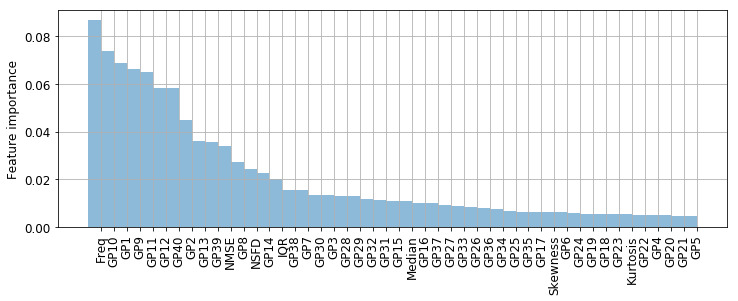

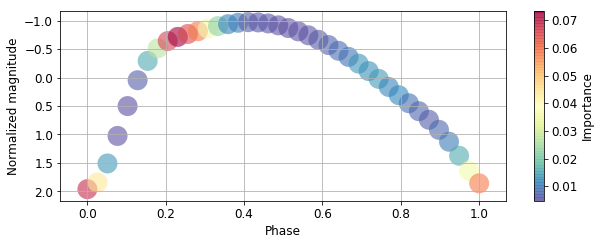

In [17]:
fidx = np.argsort(feature_importance)[::-1]

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(len(feature_importance)), feature_importance[fidx], alpha=0.5, width=1.0)
plt.xticks(np.arange(M)+0.5, np.array(feature_names)[fidx], rotation='vertical')
plt.ylabel('Feature importance')
plt.grid()

fig = plt.figure(figsize=(10, 3.5))
ax = fig.add_subplot(1, 1, 1)
avg_lc = np.average(data_P[:, :40], axis=0)
sp = ax.scatter(np.linspace(0, 1, num=40), avg_lc, s=400, c=feature_importance[:40], 
                linewidth=0, alpha=0.6, cmap=plt.cm.Spectral_r)
plt.xlabel('Phase')
plt.ylabel('Normalized magnitude')
plt.colorbar(sp, label='Importance')
plt.grid()
ax.invert_yaxis()

The frequency (period) is the most important feature. The points around $\phi=0.2$ are also important as this highlights the characteristic assymetry in the RR Lyrae light curves 

## 2D visualization of the feature space

First we try principal component analysis (PCA) to obtain a 2d visualization

Text(0.5,1,'Transduction on unlabeled data')

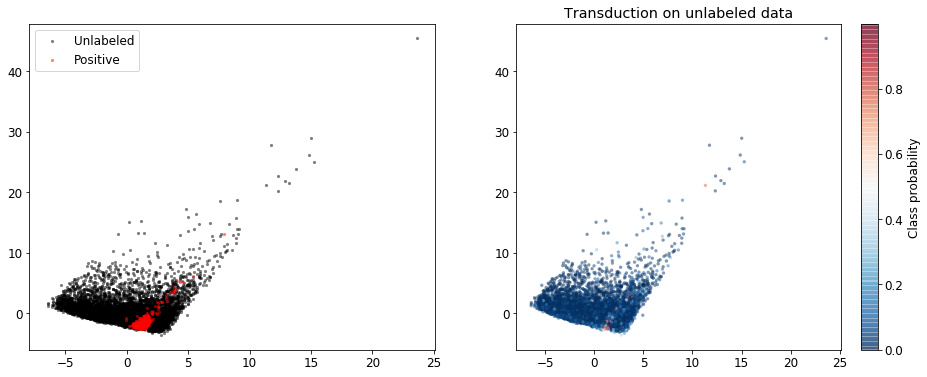

In [25]:
from sklearn.decomposition import PCA
P_pca = PCA(n_components=2).fit_transform(np.concatenate((data_P, data_U), axis=0))

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2 ,1)
ax.scatter(P_pca[NP:, 0], P_pca[NP:, 1], c='k', alpha=0.5, s=10, linewidth=0, label='Unlabeled')
ax.scatter(P_pca[:NP, 0], P_pca[:NP, 1], c='r', alpha=0.5, s=10, linewidth=0, label='Positive')
plt.legend()

ax = fig.add_subplot(1, 2 ,2)
s = ax.scatter(P_pca[NP:, 0], P_pca[NP:, 1], c=f_oob[:, 1]/n_oob, alpha=0.5, s=10, linewidth=0.1, cmap=plt.cm.RdBu_r)
plt.colorbar(s, label='Class probability')
plt.title('Transduction on unlabeled data')


In the previous plots we can see that the P class does not depart from the locus of the main distribution. Additionaly it is also not clear of clusters exists in this reduced latent space. Can we obtain a more discriminative latent space?

In the next plots we will a try a sparse autoencoder (self-taught neural network) that performs non-linear dimensionality reduction. You will see that in this case the P class occupies a clear spot in the reduced latent space. With bokeh we can generate an interactive visualization (next block) that shows the light curves mapped to the two-dimensional plot. You can inspect how the shape of the light changes as you move in this reduced latent space. Note that the autoencoder was trained offline and we only load the projections. The next code shows the tensorflow code that trains the autoencoder


Text(0.5,1,'Transduction on unlabeled data')

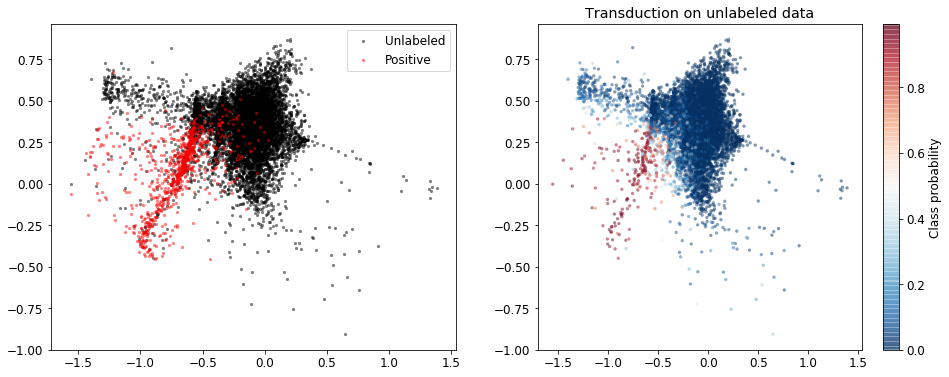

In [20]:
P = pickle.load(open("data/ae_projection.pkl", "rb"))
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2 ,1)

ax.scatter(P[NP:, 0], P[NP:, 1], c='k', alpha=0.5, s=10, linewidth=0, label='Unlabeled')
ax.scatter(P[:NP, 0], P[:NP, 1], c='r', alpha=0.5, s=10, linewidth=0, label='Positive')
plt.legend()

ax = fig.add_subplot(1, 2 ,2)
s = ax.scatter(P[NP:, 0], P[NP:, 1], c=f_oob[:, 1]/n_oob, alpha=0.5, s=10, linewidth=0.1, cmap=plt.cm.RdBu_r)
plt.colorbar(s, label='Class probability')
plt.title('Transduction on unlabeled data')


Tensorflow implementation of a fully-connected autoencoder with L2 regularization to reduce dimensionality

Interactive data visualization with Bokeh

In [18]:
features_bokeh = []
for i in range(NP):
    features_bokeh.append(np.concatenate((-1*data_P[i, :40], -1*data_P[i, :40])))
for i in range(NU):
    features_bokeh.append(np.concatenate((-1*data_U[i, :40], -1*data_U[i, :40])))

In [21]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column, row 
from bokeh.models import CustomJS, HoverTool, ColumnDataSource
import matplotlib as mpl
output_notebook()

dots = figure(width=600, height=500, tools="reset, save, box_zoom")
dots.scatter(P[:NP, 0], P[:NP, 1], size=5, alpha=0.25, marker='diamond', fill_color="black", line_color=None)

color_array = np.ones(shape=len(P,))
color_array[NP:] = probs[:, 1]
colors = ["#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.RdBu_r(mpl.colors.Normalize()(color_array))]
dots_data = ColumnDataSource(data=dict(x=P[:, 0], y=P[:, 1], period=1.0/lc_periods, color=colors))
cr = dots.circle(x='x', y='y', fill_color='color',  source=dots_data, size=5, alpha=0.5, line_color=None)

feat_sources = ColumnDataSource(data=dict(feat=features_bokeh, index=np.arange(len(P))))

feat_plot = figure(plot_width=350, plot_height=250, tools="save", y_range=(-3, 2))
feat_source = ColumnDataSource(data=dict(x=np.arange(80), y=np.zeros(shape=(80,))))
feat_plot.line(x='x', y='y', source=feat_source, line_width=4)

p = row(dots, feat_plot)

callback = CustomJS(args=dict(feat_sources=feat_sources, feat_source=feat_source), code="""
        var selected_idx = cb_data.index['1d'].indices;
        if (selected_idx.length > 0){
            var lc = feat_sources.data.feat[selected_idx[0]];
            feat_source.data['y'] = lc;
            //feat_source.data['label'] = feat_sources.data.index[selected_idx[0]].toString();
            feat_source.change.emit();
        }
    """)

dots.add_tools(HoverTool(tooltips=[("index", "$index"), ("P:", "@period")], 
                         callback=callback, renderers=[cr]))


show(p)  # open a browser

Loading BokehJS ...

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


342 light curves recovered with pbb threshold 0.50


Text(0.5,1,'Average fit in P set')

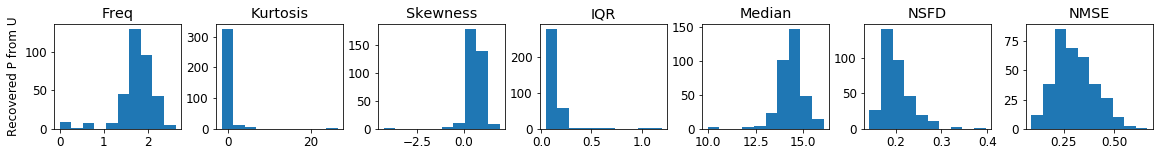

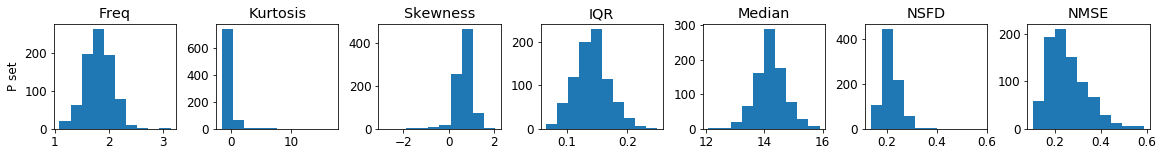

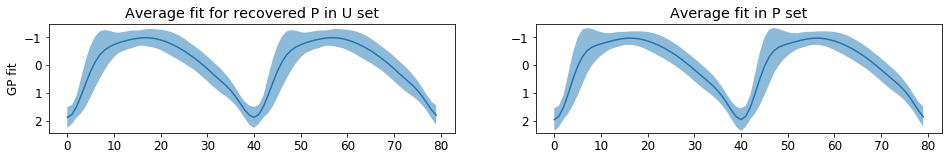

In [22]:
threshold = 0.5
mask = probs[:, 1] > threshold
print("%d light curves recovered with pbb threshold %0.2f" %(len(np.where(mask)[0]), threshold))
fig = plt.figure(figsize=(16, 2))
for i in range(7):
    ax = fig.add_subplot(1, 7, i+1)
    ax.hist(data_U[mask, -i-1])
    ax.set_title(feature_names[-i-1])
    if i == 0:
        ax.set_ylabel('Recovered P from U')
plt.tight_layout(pad=0.1)

fig = plt.figure(figsize=(16, 2))
for i in range(7):
    ax = fig.add_subplot(1, 7, i+1)
    ax.hist(data_P[:, -i-1])
    ax.set_title(feature_names[-i-1])
    if i == 0:
        ax.set_ylabel('P set')
plt.tight_layout(pad=0.1)

fig = plt.figure(figsize=(16, 2))

ax = fig.add_subplot(1, 2, 1)
class_mu = np.mean(data_U[mask, :40], axis=0)
class_std = np.std(data_U[mask, :40], axis=0)
ax.plot(range(80), np.tile(class_mu, 2))
ax.fill_between(range(80), np.tile(class_mu - 2*class_std,2), np.tile(class_mu + 2*class_std,2), alpha=0.5)
ax.invert_yaxis()
ylims = ax.get_ylim()
plt.ylabel("GP fit")
plt.title("Average fit for recovered P in U set")
ax = fig.add_subplot(1, 2, 2)
class_mu = np.mean(data_P[:, :40], axis=0)
class_std = np.std(data_P[:, :40], axis=0)
ax.plot(range(80), np.tile(class_mu, 2))
ax.fill_between(range(80), np.tile(class_mu - 2*class_std,2), np.tile(class_mu + 2*class_std,2), alpha=0.5)
ax.invert_yaxis()
ax.set_ylim(ylims)
plt.title("Average fit in P set")

We can see that the distribution of the features of the light curves recovered from U is very similar to the distribution of the features of P

We can also inspect the actual light curves from U that have the highest probability of being RR Lyrae. We load the data and plot the light curves in descending order of probability of being an RR Lyrae.

In [23]:
import gzip
with gzip.GzipFile("data/lc_data.pgz", 'r') as f:
    lc_raw, lc_period_raw = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/lc_data.pgz'

missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missing label
missin

KeyboardInterrupt: 

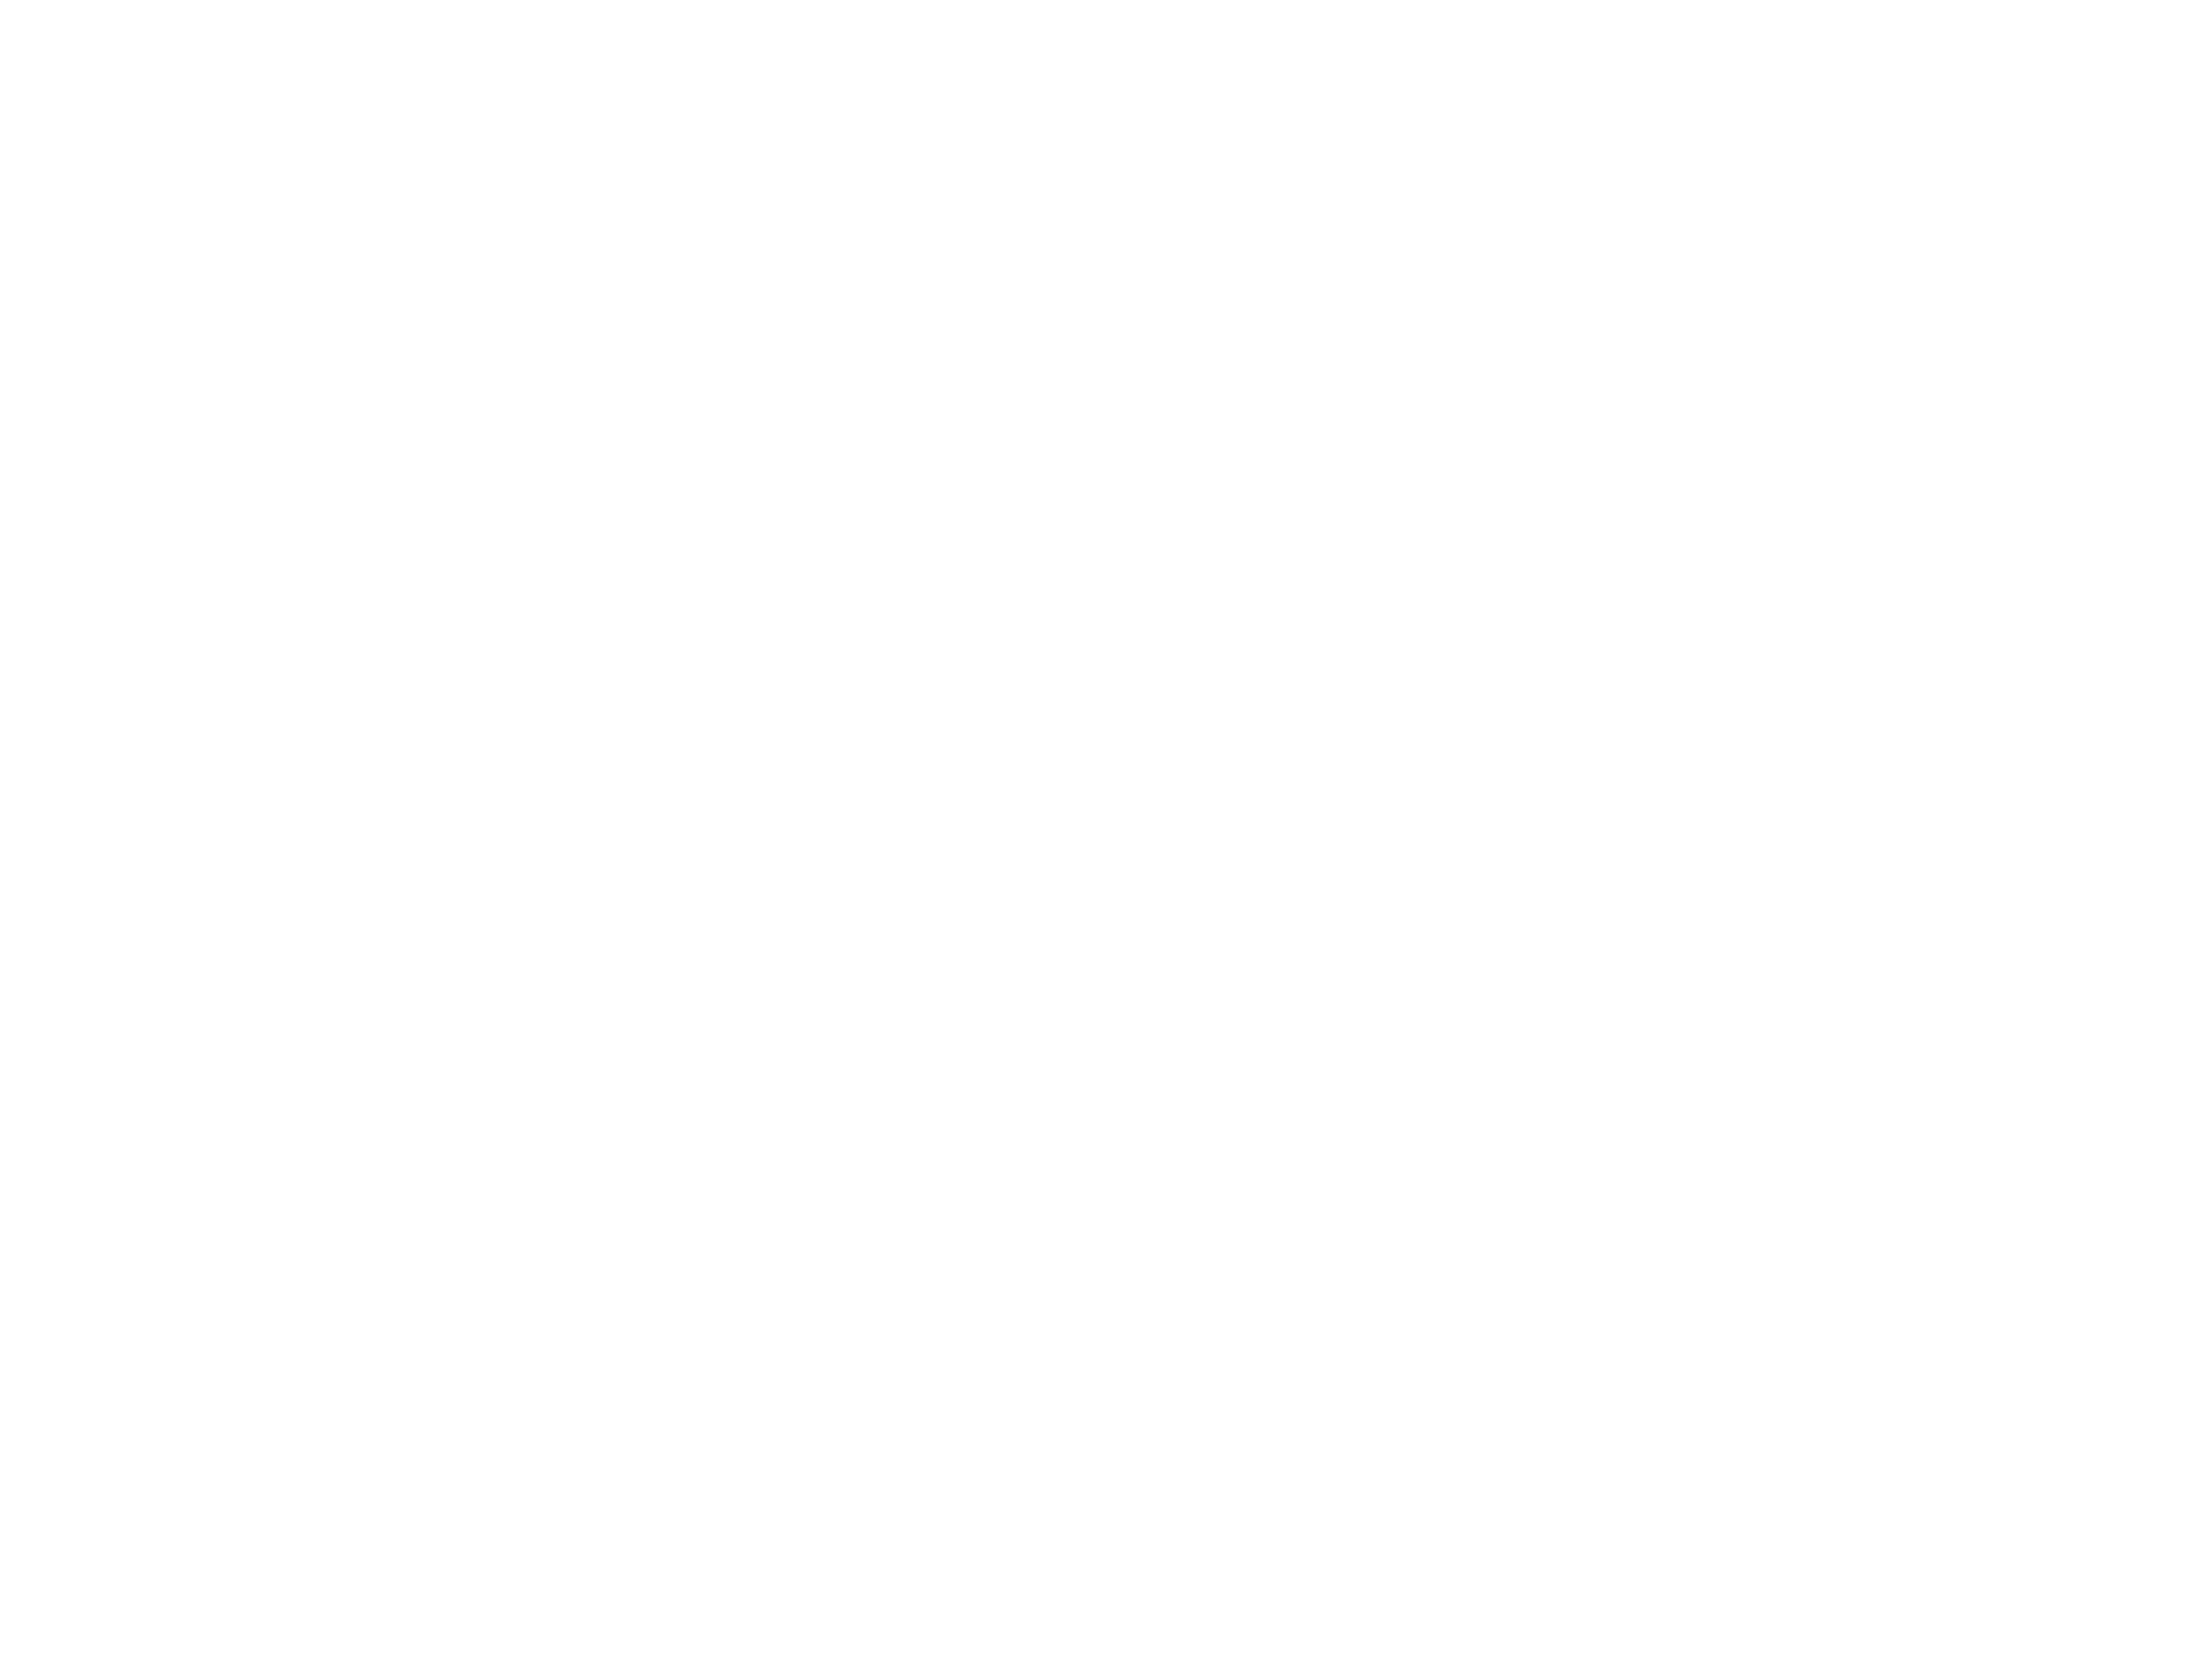

In [24]:
fig = plt.figure(figsize=(18, 14), dpi=150)
sorted_conf = np.argsort(probs[:, 1])[::-1]
for i in range(10*10):
    ax = fig.add_subplot(10, 10, i+1)
    try:
        idx = NP+sorted_conf[i]
        mjd = lc_raw[idx][:, 0]
        mag = lc_raw[idx][:, 1]
        err = lc_raw[idx][:, 2]
        plt.axis('off')
        
        p_fold = lc_period_raw[idx]
        phase = np.mod(mjd, p_fold)/p_fold
        I = np.argsort(phase)
        ax.errorbar(np.concatenate([np.sort(phase), np.sort(phase)+1.0]), 
                    np.concatenate([-mag[I], -mag[I]]),
                    np.concatenate([err[I], err[I]]), fmt='.')
    except:
        print("missing label")
        plt.axis('off')
plt.tight_layout(pad=0.1)